# Real data application: Inverting the slickenslide data set provided in Angelier 1979 (https://doi.org/10.1016/0040-1951(79)90081-7)

In [1]:
import os
import sys

# import the iterative linear stress inversion package
sys.path.append('/home/eric/Dropbox (MIT)/package_stress_inversion/ILSI')
import ILSI

import numpy as np
import h5py as h5
import pandas as pd
import matplotlib.pyplot as plt
from time import time as give_time

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.colorbar as clb
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import mplstereonet

# set plotting parameters
import seaborn as sns
sns.set()
sns.set_style('ticks')
sns.set_palette('colorblind')
#sns.set_context('paper')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['svg.fonttype'] = 'none'

# define the color palette
_colors_ = ['C0', 'C1']

## Load the data

In [3]:
data_path = '/home/eric/Dropbox (MIT)/package_stress_inversion/ILSI/tests/data/'
data = pd.read_csv(os.path.join(data_path, 'central_Crete.csv'))

strikes_1 = data['strike'].values
dips_1 = data['dip'].values
rakes_1 = np.float32(data['rake'].values)%360.
n_earthquakes = len(strikes_1)
strikes_2, dips_2, rakes_2 = \
         np.asarray(list(map(ILSI.utils_stress.aux_plane, strikes_1, dips_1, rakes_1))).T

## Run the stress inversion

Running this script with the stress inversion parameters that I prodives takes ~ 1.5 minutes on my laptop.

In [6]:
def stress_inversion(strikes_1, dips_1, rakes_1):
    t_start_experiment = give_time()
    n_earthquakes = len(strikes_1)
    strikes_2, dips_2, rakes_2 = \
         np.asarray(list(map(ILSI.utils_stress.aux_plane, strikes_1, dips_1, rakes_1))).T
    # --------------------------------
    #    stress tensor inversion
    # --------------------------------
    # inversion parameter
    friction_min = 0.1
    friction_max = 0.8
    friction_step = 0.05
    n_random_selections = 30
    n_stress_iter = 20
    n_averaging = 5
    n_bootstraps = 1000
    ILSI_kwargs = {}
    ILSI_kwargs['max_n_iterations'] = 1000
    ILSI_kwargs['shear_update_atol'] = 1.e-7
    Tarantola_kwargs0 = {}
    # --------------------------------
    # initialize output dictionary
    # --------------------------------
    inversion_output = {}
    for experiment in ['true_fp_linear', 'true_fp_iterative']:
        inversion_output[experiment] = {}
        inversion_output[experiment]['stress_tensor'] =\
                np.zeros((3, 3), dtype=np.float32)
        inversion_output[experiment]['principal_stresses'] =\
                np.zeros(3, dtype=np.float32)
        inversion_output[experiment]['principal_directions'] =\
                np.zeros((3, 3), dtype=np.float32)
        inversion_output[experiment]['misfit'] = 0.
        inversion_output[experiment]['boot_stress_tensor'] =\
                np.zeros((n_bootstraps, 3, 3), dtype=np.float32)
        inversion_output[experiment]['boot_principal_stresses'] =\
                np.zeros((n_bootstraps, 3), dtype=np.float32)
        inversion_output[experiment]['boot_principal_directions'] =\
                np.zeros((n_bootstraps, 3, 3), dtype=np.float32)
        inversion_output[experiment]['boot_misfit'] = np.zeros(n_bootstraps, dtype=np.float32)
    # ----------- whole data set
    inversion_output['true_fp_linear']['stress_tensor'],\
    inversion_output['true_fp_linear']['principal_stresses'],\
    inversion_output['true_fp_linear']['principal_directions'] =\
               ILSI.ilsi.Michael1984_inversion(
                       strikes_1, dips_1, rakes_1,
                    return_eigen=True, return_stats=False,
                       Tarantola_kwargs=Tarantola_kwargs0)
    inversion_output['true_fp_linear']['misfit'] =\
            np.mean(ILSI.utils_stress.mean_angular_residual(
                inversion_output['true_fp_linear']['stress_tensor'],
                strikes_1, dips_1, rakes_1))
    inversion_output['true_fp_iterative']['stress_tensor'], _,\
    inversion_output['true_fp_iterative']['principal_stresses'],\
    inversion_output['true_fp_iterative']['principal_directions'] =\
               ILSI.ilsi.iterative_linear_si(
                       strikes_1, dips_1, rakes_1,
                       return_eigen=True, return_stats=False,
                       Tarantola_kwargs=Tarantola_kwargs0, **ILSI_kwargs)
    inversion_output['true_fp_iterative']['misfit'] =\
            np.mean(ILSI.utils_stress.mean_angular_residual(
                inversion_output['true_fp_iterative']['stress_tensor'],
                strikes_1, dips_1, rakes_1))
    # ----------- bootstrapped data set
    for b in range(n_bootstraps):
        bootstrapped_set = np.random.choice(
                np.arange(n_earthquakes), replace=True, size=n_earthquakes)
        strikes_b, dips_b, rakes_b = strikes_1[bootstrapped_set], dips_1[bootstrapped_set], rakes_1[bootstrapped_set]
        inversion_output['true_fp_linear']['boot_stress_tensor'][b, ...],\
        inversion_output['true_fp_linear']['boot_principal_stresses'][b, ...],\
        inversion_output['true_fp_linear']['boot_principal_directions'][b, ...] =\
                   ILSI.ilsi.Michael1984_inversion(
                           strikes_b, dips_b, rakes_b,
                           return_eigen=True, return_stats=False,
                           Tarantola_kwargs=Tarantola_kwargs0)
        inversion_output['true_fp_linear']['boot_misfit'][b] =\
                np.mean(ILSI.utils_stress.mean_angular_residual(
                    inversion_output['true_fp_linear']['boot_stress_tensor'][b, ...],
                    strikes_b, dips_b, rakes_b))
        inversion_output['true_fp_iterative']['boot_stress_tensor'][b, ...], _,\
        inversion_output['true_fp_iterative']['boot_principal_stresses'][b, ...],\
        inversion_output['true_fp_iterative']['boot_principal_directions'][b, ...] =\
                   ILSI.ilsi.iterative_linear_si(
                           strikes_b, dips_b, rakes_b,
                           return_eigen=True, return_stats=False,
                           Tarantola_kwargs=Tarantola_kwargs0, **ILSI_kwargs)
        inversion_output['true_fp_iterative']['boot_misfit'][b] =\
                np.mean(ILSI.utils_stress.mean_angular_residual(
                    inversion_output['true_fp_iterative']['boot_stress_tensor'][b, ...],
                    strikes_b, dips_b, rakes_b))
    inversion_output['strikes'] = np.stack((strikes_1, strikes_2), axis=1)
    inversion_output['dips'] = np.stack((dips_1, dips_2), axis=1)
    inversion_output['rakes'] = np.stack((rakes_1, rakes_2), axis=1)
    t_end_experiment = give_time()
    print('Done! The inversion ran in {:.2f} seconds'.
         format(t_end_experiment-t_start_experiment))
    return inversion_output

In [7]:
# run the stress inversion
inversion_output = stress_inversion(strikes_1, dips_1, rakes_1)

Done! The inversion ran in 81.40 seconds


## Plot the results

Define plotting routines and use them to reproduce the figures shown in the paper.

In [9]:
def plot_inverted_stress_tensors(inversion_output, axes=None, **kwargs):
    hist_kwargs = {}
    hist_kwargs['smoothing_sig'] = kwargs.get('smoothing_sig', 1)
    hist_kwargs['nbins'] = kwargs.get('nbins', 200)
    hist_kwargs['return_count'] = kwargs.get('return_count', True)
    hist_kwargs['confidence_intervals'] = kwargs.get('confidence_intervals', [95.])
    markers = ['o', 's', 'v']
    methods = ['linear', 'iterative']
    n_bootstraps = inversion_output['true_fp_linear']['boot_principal_directions'].shape[0]
    fig = plt.figure('inverted_stress_tensors_Crete', figsize=(18, 9))
    fig.suptitle('Central Crete')
    gs1 = fig.add_gridspec(nrows=3, ncols=3, top=0.88, bottom=0.11,
                           left=0.05, right=0.95, hspace=0.4, wspace=0.4)
    gs2 = fig.add_gridspec(nrows=3, ncols=3, top=0.88, bottom=0.11,
                           left=0.20, right=0.80, hspace=0.4, wspace=0.7)
    axes = []
    ax1 = fig.add_subplot(gs2[0, 1], projection='stereonet')
    ax2 = fig.add_subplot(gs2[0, 2])
    ax3 = fig.add_subplot(gs2[0, 0], projection='stereonet')
    ax3.set_title('Fault planes', pad=30)
    ax3.plane(inversion_output['strikes'][:, 0],
              inversion_output['dips'][:, 0], color='k', lw=1.0)
    for j, method in enumerate(methods):
        exp = f'true_fp_{method}'
        R = ILSI.utils_stress.R_(inversion_output[exp]['principal_stresses'])
        for k in range(3):
            if k == 0:
                label = '{}:\n'.format(method.replace('_', ' ').capitalize())
                for k2 in range(3):
                    az, pl = ILSI.utils_stress.get_bearing_plunge(
                            inversion_output[exp]['principal_directions'][:, k2])
                    label += r'$\sigma_{{{:d}}}$: {:.1f}'u'\u00b0''|{:.1f}'u'\u00b0'', '.\
                            format(k2+1, az, pl)
                label += ' R={:.2f}, $\\vert{{\\Delta \\theta}}\\vert$={:.1f}'u'\u00b0'.\
                        format(R, inversion_output[exp]['misfit'])
            else:
                label = ''
            az, pl = ILSI.utils_stress.get_bearing_plunge(
                    inversion_output[exp]['principal_directions'][:, k])
            ax1.line(pl, az, marker=markers[k], markeredgecolor=_colors_[j], markeredgewidth=2,
                     markerfacecolor='none', markersize=[15, 15][j], label=label, zorder=2)
            boot_pd_stereo = np.zeros((n_bootstraps, 2), dtype=np.float32)
            for b in range(n_bootstraps):
                boot_pd_stereo[b, :] = ILSI.utils_stress.get_bearing_plunge(
                        inversion_output[exp]['boot_principal_directions'][b, :, k])
            count, lons_g, lats_g, levels = ILSI.utils_stress.get_CI_levels(
                    boot_pd_stereo[:, 0], boot_pd_stereo[:, 1], **hist_kwargs)
            ax1.contour(lons_g, lats_g, count, levels=levels, vmin=0.,
                        linestyles=['solid', 'dashed', 'dashdot'][k],
                        linewidths=0.75, colors=_colors_[j])
        axes.append(ax1)
        Rs = np.zeros(n_bootstraps, dtype=np.float32)
        for b in range(n_bootstraps):
            Rs[b] = ILSI.utils_stress.R_(inversion_output[exp]['boot_principal_stresses'][b, :])
        ax2.hist(Rs, range=(0., 1.), bins=20, lw=2.5, color=_colors_[j], histtype='step')
    ax2.set_xlabel('Shape Ratio')
    ax2.set_ylabel('Count')
    for ax in axes:
        #ax.grid(True)
        ax.legend(loc='upper left', bbox_to_anchor=(-0.5, -0.30))
    plt.subplots_adjust(top=0.88, bottom=0.11,
                        left=0.05, right=0.95,
                        hspace=0.4, wspace=0.4)
    return fig

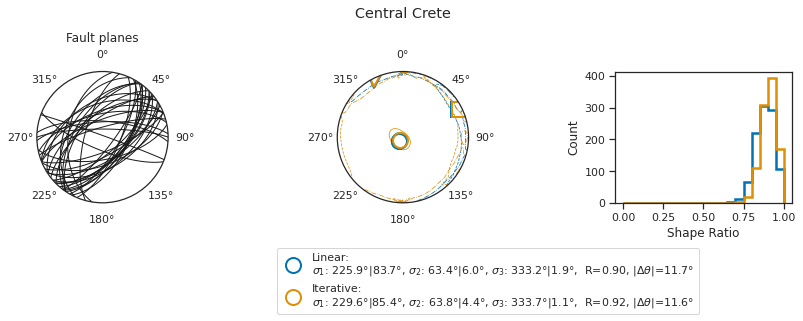

In [10]:
fig = plot_inverted_stress_tensors(inversion_output, smoothing_sig=4)